In [12]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math

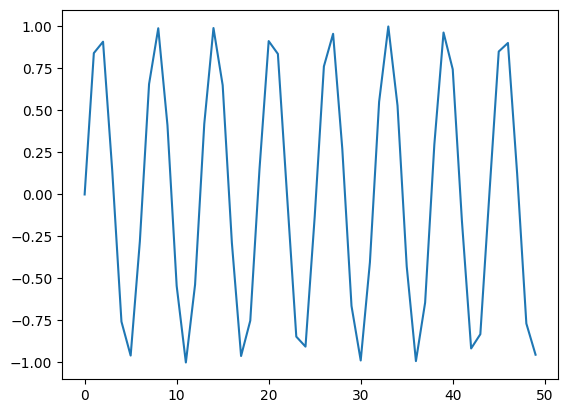

In [13]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
# Visualizing the sine wave we’ve just generated:
plt.plot(sin_wave[:50]) # plot the sine wave

In [14]:
X = []
Y = []
seq_len = 50
num_records = len(sin_wave) - seq_len
for i in range(num_records - 50):
  X.append(sin_wave[i:i+seq_len])
  Y.append(sin_wave[i+seq_len])

X = np.array(X)
X = np.expand_dims(X, axis=2)
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [15]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [16]:
X_val = []
Y_val = []
for i in range(num_records - 50, num_records):
  X_val.append(sin_wave[i:i+seq_len])
  Y_val.append(sin_wave[i+seq_len])
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)
Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [22]:
learning_rate = 0.0001
nepoch = 10
T = 50 # length of sequence
hidden_dim = 100
output_dim = 1
bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10
# We will then define the weights of the network:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [23]:
def sigmoid(value):
  return 1/(1+np.exp(-value))

In [24]:
for epoch in range(nepoch):
# check loss on train
  loss = 0.0
  # do a forward pass to get prediction
  for i in range(Y.shape[0]):
    x, y = X[i], Y[i]

    prev_s = np.zeros((hidden_dim, 1))

    for t in range(T):
      new_input = np.zeros(x.shape)

      new_input[t] = x[t]
      mulu = np.dot(U, new_input)
      mulw = np.dot(W, prev_s)
      add = mulw + mulu
      s = sigmoid(add)
      mulv = np.dot(V, s)
      prev_s = s

    # calculate error
    loss_per_record = (y - mulv)**2 / 2
    loss += loss_per_record

  loss = loss / float(y.shape[0])
  # check loss on val
  val_loss = 0.0
  for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    for t in range(T):
      new_input = np.zeros(x.shape)
      new_input[t] = x[t]
      mulu = np.dot(U, new_input)
      mulw = np.dot(W, prev_s)
      add = mulw + mulu
      s = sigmoid(add)
      mulv = np.dot(V, s)
      prev_s = s
    loss_per_record = (y - mulv)**2 / 2
    val_loss += loss_per_record
  val_loss = val_loss / float(y.shape[0])
  print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
  # train model
  for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    layers = []
    prev_s = np.zeros((hidden_dim, 1))
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    # forward pass
    for t in range(T):
      new_input = np.zeros(x.shape)
      new_input[t] = x[t]
      mulu = np.dot(U, new_input)
      mulw = np.dot(W, prev_s)
      add = mulw + mulu
      s = sigmoid(add)
      mulv = np.dot(V, s)
      layers.append({'s':s, 'prev_s':prev_s})
      prev_s = s
      # derivative of pred
    dmulv = (mulv - y)
    # backward pass
    for t in range(T):
      dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
      dsv = np.dot(np.transpose(V), dmulv)
      ds = dsv
      dadd = add * (1 - add) * ds
      dmulw = dadd * np.ones_like(mulw)
      dprev_s = np.dot(np.transpose(W), dmulw)
      for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
        ds = dsv + dprev_s
        dadd = add * (1 - add) * ds
        dmulw = dadd * np.ones_like(mulw)
        dmulu = dadd * np.ones_like(mulu)
        dW_i = np.dot(W, layers[t]['prev_s'])
        dprev_s = np.dot(np.transpose(W), dmulw)
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        dU_i = np.dot(U, new_input)
        dx = np.dot(np.transpose(U), dmulu)
        dU_t += dU_i
        dW_t += dW_i
      dV += dV_t
      dU += dU_t
      dW += dW_t

      if dU.max() > max_clip_value:
        dU[dU > max_clip_value] = max_clip_value
      if dV.max() > max_clip_value:
        dV[dV > max_clip_value] = max_clip_value
      if dW.max() > max_clip_value:
        dW[dW > max_clip_value] = max_clip_value
      if dU.min() < min_clip_value:
        dU[dU < min_clip_value] = min_clip_value
      if dV.min() < min_clip_value:
        dV[dV < min_clip_value] = min_clip_value
      if dW.min() < min_clip_value:
        dW[dW < min_clip_value] = min_clip_value

    # update
    U -= learning_rate * dU
    V -= learning_rate * dV
    W -= learning_rate * dW


Epoch:  1 , Loss:  [[108201.8860188]] , Val Loss:  [[54099.10907425]]
Epoch:  2 , Loss:  [[66688.02613331]] , Val Loss:  [[33342.56490556]]
Epoch:  3 , Loss:  [[35174.16624777]] , Val Loss:  [[17586.02073686]]
Epoch:  4 , Loss:  [[13660.30642763]] , Val Loss:  [[6829.47660085]]
Epoch:  5 , Loss:  [[2153.2446881]] , Val Loss:  [[1076.33397501]]
Epoch:  6 , Loss:  [[27.33510079]] , Val Loss:  [[13.63057186]]
Epoch:  7 , Loss:  [[23.63936133]] , Val Loss:  [[11.78944893]]
Epoch:  8 , Loss:  [[23.13716]] , Val Loss:  [[11.53329441]]
Epoch:  9 , Loss:  [[22.86284024]] , Val Loss:  [[11.39890198]]
Epoch:  10 , Loss:  [[22.90336423]] , Val Loss:  [[11.42003668]]


In [25]:
preds = []
for i in range(Y.shape[0]):
  x, y = X[i], Y[i]
  prev_s = np.zeros((hidden_dim, 1))
  # Forward pass
  for t in range(T):
    mulu = np.dot(U, x)
    mulw = np.dot(W, prev_s)
    add = mulw + mulu
    s = sigmoid(add)
    mulv = np.dot(V, s)
    prev_s = s
  preds.append(mulv)
preds = np.array(preds)

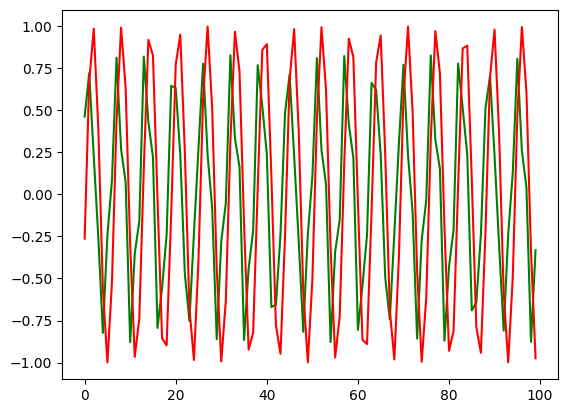

In [26]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

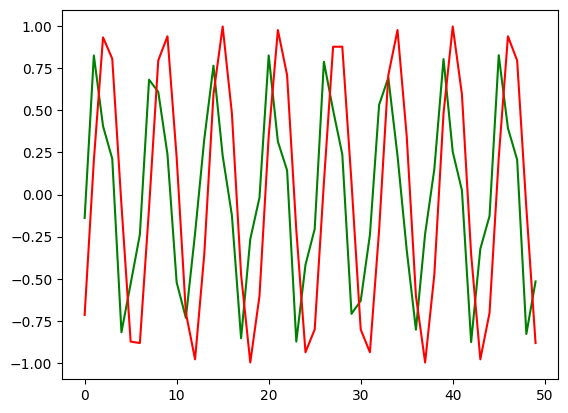

In [27]:
preds = []
for i in range(Y_val.shape[0]):
  x, y = X_val[i], Y_val[i]
  prev_s = np.zeros((hidden_dim, 1))
  # For each time step...
  for t in range(T):
    mulu = np.dot(U, x)
    mulw = np.dot(W, prev_s)
    add = mulw + mulu
    s = sigmoid(add)
    mulv = np.dot(V, s)
    prev_s = s
  preds.append(mulv)
preds = np.array(preds)
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()


(50, 1)

#Sentiment Analysis


In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
!unzip data.zip
!rm data.zip

Archive:  data.zip
replace labels.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: labels.txt              
  inflating: reviews.txt             


In [ ]:
with open('reviews.txt', 'r') as f:
  reviews = f.read()
with open('labels.txt', 'r') as f:
  labels = f.read()


# New section

# New section

In [ ]:
reviews[:2000]


'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   \nstory of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is tu

In [ ]:
from string import punctuation
all_text = ''.join([c for c in reviews if c not in punctuation])
reviews = all_text.split('\n')
all_text = ' '.join(reviews)
words = all_text.split()


In [ ]:
all_text[:2000]

'bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t    story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  violent m

In [ ]:
words[:100]


['bromwell',
 'high',
 'is',
 'a',
 'cartoon',
 'comedy',
 'it',
 'ran',
 'at',
 'the',
 'same',
 'time',
 'as',
 'some',
 'other',
 'programs',
 'about',
 'school',
 'life',
 'such',
 'as',
 'teachers',
 'my',
 'years',
 'in',
 'the',
 'teaching',
 'profession',
 'lead',
 'me',
 'to',
 'believe',
 'that',
 'bromwell',
 'high',
 's',
 'satire',
 'is',
 'much',
 'closer',
 'to',
 'reality',
 'than',
 'is',
 'teachers',
 'the',
 'scramble',
 'to',
 'survive',
 'financially',
 'the',
 'insightful',
 'students',
 'who',
 'can',
 'see',
 'right',
 'through',
 'their',
 'pathetic',
 'teachers',
 'pomp',
 'the',
 'pettiness',
 'of',
 'the',
 'whole',
 'situation',
 'all',
 'remind',
 'me',
 'of',
 'the',
 'schools',
 'i',
 'knew',
 'and',
 'their',
 'students',
 'when',
 'i',
 'saw',
 'the',
 'episode',
 'in',
 'which',
 'a',
 'student',
 'repeatedly',
 'tried',
 'to',
 'burn',
 'down',
 'the',
 'school',
 'i',
 'immediately',
 'recalled',
 'at',
 'high']

In [ ]:
print(type(reviews), len(reviews), reviews[0],'last review:',
reviews[25000])

<class 'list'> 25001 bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t    last review: 


In [ ]:
from collections import Counter
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
reviews_ints = []
for each in reviews:
  reviews_ints.append([vocab_to_int[word] for word in each.split()])

In [ ]:
labels = labels.split('\n')
labels = np.array([1 if label == 'positive' else 0 for label in labels])

In [ ]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


In [ ]:
# Filter out that review with 0 length
non_zero = [l for l, review in enumerate(reviews_ints) if len(review) != 0]
reviews_ints = [reviews_ints[l] for l in non_zero]
labels = np.array([labels[l] for l in non_zero])

In [ ]:
def pad_features(reviews_ints, seq_length):

  features = np.zeros((len(reviews_ints), seq_length), dtype=int)

  # for each review, I grab that review and
  for i, row in enumerate(reviews_ints):
      features[i, -len(row):] = np.array(row)[:seq_length]

  return features

In [ ]:
seq_length = 200

features = pad_features(reviews_ints,seq_length)

In [ ]:
features[:10,:100]


array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 21025,   308,     6,
            3,  1050,   207,     8,  2138,    32,     1,   171,    57,
           15,    49,    81,  5785,    44,   382,   110,   140,    15,
         5194,    60,   154,     9,     1,  4975,  5852,   475,    71,
            5,   260,    12, 21025,   308,    13,  1978,     6,    74,
         2395],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

In [ ]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


In [ ]:
lstm_size = 256
lstm_layers = 1
batch_size = 500
learning_rate = 0.001

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# inputs_ = tf.placeholder(tf.float32, shape=(74000, 300), name='inputs')
# labels_ = tf.placeholder(tf.int32, shape=(2, 1), name='labels')
# keep_prob = tf.placeholder(tf.float32, name='keep_prob')

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
n_words = len(vocab_to_int) + 1
# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name = "inputs")
    labels_ = tf.placeholder(tf.int32, [None, None], name = "labels")
    keep_prob = tf.placeholder(tf.float32, name = "keep_prob")

In [ ]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)
    lstm = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(lstm_size)

    # Add dropout to the cell
    drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob = keep_prob)

    # Stack up multiple LSTM layers, for deep learning
    cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([drop] * lstm_layers)

    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

<ipython-input-32-b8423c82bf78>:7: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(lstm_size)


In [ ]:
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state = initial_state)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
final_output = outputs[:, -1]
with graph.as_default():
    predictions = tf.sigmoid(final_output)
    cost = tf.losses.mean_squared_error(labels_, predictions)

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
def get_batches(x, y, batch_size=100):

    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for l in range(0, len(x), batch_size):
        yield x[l:l+batch_size], y[l:l+batch_size]

In [ ]:
epochs = 10

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)

        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)

            if iteration%5==0:
                print("Epoch: {}/{}".format(e + 1, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")

Epoch: 1/10 Iteration: 5 Train loss: 0.251
Epoch: 1/10 Iteration: 10 Train loss: 0.251
Epoch: 1/10 Iteration: 15 Train loss: 0.244
Epoch: 1/10 Iteration: 20 Train loss: 0.244
Epoch: 1/10 Iteration: 25 Train loss: 0.248
Val acc: 0.621
Epoch: 1/10 Iteration: 30 Train loss: 0.245
Epoch: 1/10 Iteration: 35 Train loss: 0.237
Epoch: 1/10 Iteration: 40 Train loss: 0.238
Epoch: 2/10 Iteration: 45 Train loss: 0.232
Epoch: 2/10 Iteration: 50 Train loss: 0.240
Val acc: 0.573
Epoch: 2/10 Iteration: 55 Train loss: 0.225
Epoch: 2/10 Iteration: 60 Train loss: 0.224
Epoch: 2/10 Iteration: 65 Train loss: 0.222
Epoch: 2/10 Iteration: 70 Train loss: 0.221
Epoch: 2/10 Iteration: 75 Train loss: 0.220
Val acc: 0.514
Epoch: 2/10 Iteration: 80 Train loss: 0.219
Epoch: 3/10 Iteration: 85 Train loss: 0.263
Epoch: 3/10 Iteration: 90 Train loss: 0.261
Epoch: 3/10 Iteration: 95 Train loss: 0.245
Epoch: 3/10 Iteration: 100 Train loss: 0.239
Val acc: 0.523
Epoch: 3/10 Iteration: 105 Train loss: 0.236
Epoch: 3/10 Ite

In [ ]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

Test accuracy: 0.708
